In [2]:
# Data
import numpy as np
import pandas  as pd

# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torch.utils.data as data
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Evaluation 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

In [3]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


scaler = torch.amp.GradScaler() if device.type == "cuda" else None

Using device: cuda


In [4]:
def load_data_in_chunks(file_path, chunksize=10000):
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

In [5]:
weather = load_data_in_chunks('/home/kzaman/weather/weather.csv')
weather.index = pd.to_datetime(weather['datetime'], format='%m/%d/%Y %H:%M')
weather = weather.fillna(method='ffill')

/tmp/ipykernel_309729/2525802060.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather = weather.fillna(method='ffill')


In [6]:
weather.isnull().sum()

datetime            0
Wind Speed          0
Wind Direction      0
Solar Irradiance    0
Temperature         0
Clearness index     0
dtype: int64

In [7]:
weather.tail()

,datetime,Wind Speed,Wind Direction,Solar Irradiance,Temperature,Clearness index
datetime,,,,,,
2023-12-31 19:00:00,12/31/2023 19:00,4.99,323.02,0.0,21.12,-999.0
2023-12-31 20:00:00,12/31/2023 20:00,5.25,320.25,0.0,20.61,-999.0
2023-12-31 21:00:00,12/31/2023 21:00,5.39,320.77,0.0,20.14,-999.0
2023-12-31 22:00:00,12/31/2023 22:00,5.61,324.76,0.0,19.69,-999.0
2023-12-31 23:00:00,12/31/2023 23:00,5.91,329.57,0.0,19.20,-999.0


In [8]:
import pandas as pd

# Let's assume your full data is in a DataFrame called `df`
# and the datetime column is named 'datetime' and already parsed.


# Step 3: Define the split
train_df = weather.loc[:'2022-12-31 23:00:00']  # Up to end of 19th year
test_df = weather.loc['2023-01-01 00:00:00':]   # Start of 20th year

# Step 4: Check the result
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")


Train set shape: (166560, 6)
Test set shape: (8760, 6)


In [9]:
test_df.head()

,datetime,Wind Speed,Wind Direction,Solar Irradiance,Temperature,Clearness index
datetime,,,,,,
2023-01-01 00:00:00,1/1/2023 0:00,4.33,18.96,0.0,18.42,-999.0
2023-01-01 01:00:00,1/1/2023 1:00,4.64,24.24,0.0,17.99,-999.0
2023-01-01 02:00:00,1/1/2023 2:00,4.75,29.48,0.0,17.63,-999.0
2023-01-01 03:00:00,1/1/2023 3:00,4.58,30.46,0.0,17.36,-999.0
2023-01-01 04:00:00,1/1/2023 4:00,4.34,26.89,0.0,17.12,-999.0


In [10]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175320 entries, 2004-01-01 00:00:00 to 2023-12-31 23:00:00
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   datetime          175320 non-null  object 
 1   Wind Speed        175320 non-null  float64
 2   Wind Direction    175320 non-null  float64
 3   Solar Irradiance  175320 non-null  float64
 4   Temperature       175320 non-null  float64
 5   Clearness index   175320 non-null  float64
dtypes: float64(5), object(1)
memory usage: 13.4+ MB


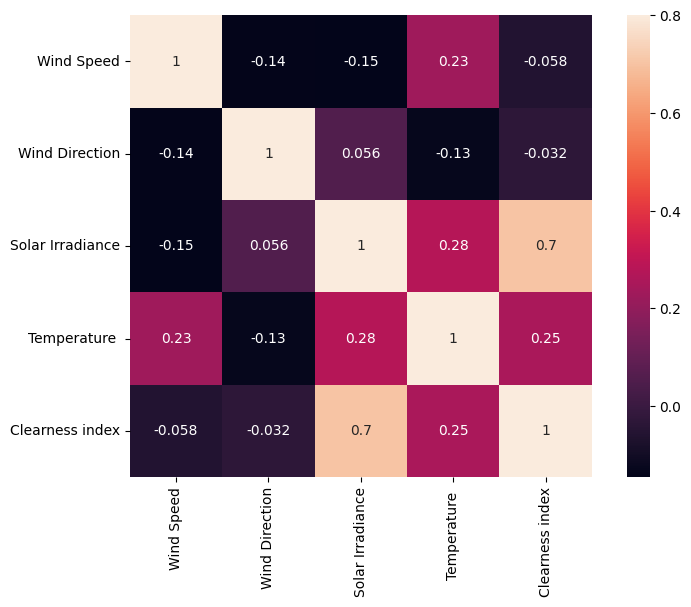

In [11]:
correlation_matrix = train_df.iloc[:,1:].corr()
fig = plt.figure(figsize=(9,6))
sns.heatmap(correlation_matrix,vmax=0.8,square = True, annot= True)
plt.show()

In [11]:
# Box Plot / Line Plot
class plotly_graph:
    def __init__(self, data, date):
        self.data = data
        self.date = date
        self.name_lst = ['Wind Speed', 'Wind Direction', 'Solar Irradiance', 'Temperature ', 'Clearness index']
        self.box_title = 'Multiple Box Plots'
        self.line_title = 'Multiple Line Plots'
    
#################### function to make subplots ######################
    def make_subplot(self, graphs):
        fig = make_subplots(rows=2, cols=2, subplot_titles=(self.name_lst))
        for i in range(5): fig.add_trace(graphs[i], row=i // 2 + 1, col=i % 2 + 1)
        return fig
    
#################### 1. Box Plot ######################
    def box_plot(self):
        graph_lsts = []
        for i, element in enumerate(self.data.transpose()):
            graph_lst = go.Box(y = element,
                               name = self.box_title,
                               boxpoints = 'outliers',
                               line = dict(width=1))    
            graph_lsts.append(graph_lst)
        fig = self.make_subplot(graph_lsts)
        fig.update_layout(title=self.box_title,
                          xaxis_title='Columns',
                          yaxis_title='Values',
                          template = 'simple_white')
        fig.show()

#################### 2. Line Plot ######################
    def line_plot(self):
        line_lsts = []
        for i, element in enumerate(self.data.transpose()):
            line = go.Scatter(x = self.date,
                               y = element,
                               mode = 'lines',
                               name = self.line_title)
            line_lsts.append(line)
        fig = self.make_subplot(line_lsts)
        fig.update_layout(title=self.line_title,
                          xaxis_title='Columns',
                          yaxis_title='Values',
                          template = 'simple_white')
        fig.show()

In [12]:
data_ = train_df[['Wind Speed', 'Wind Direction', 'Solar Irradiance', 'Temperature ', 'Clearness index']].values

graph = plotly_graph(data_, train_df['datetime'])

In [14]:
# graph.box_plot()

In [51]:
# graph.line_plot()

In [12]:
cols_to_convert = [col for col in weather.columns if col != 'datetime']
cols_to_convert

['Wind Speed',
 'Wind Direction',
 'Solar Irradiance',
 'Temperature ',
 'Clearness index']

In [13]:
for col in cols_to_convert:
    if train_df[col].dtype == 'object':
        train_df[col] = train_df[col].str.replace(',', '').astype(float)

print("Data loaded and preprocessed. Shape:", train_df.shape)

Data loaded and preprocessed. Shape: (166560, 6)


In [54]:
# new = pd.concat([train_df, test_df], axis=0).reset_index().drop('index', axis=1)
# new_timeseries = new[['month', 'day',  'humidity', 'wind_speed', 'meanpressure',  'humidity_pressure_ratio', 'meantemp']].values.astype('float32')

In [14]:
tr_timeseries = train_df[cols_to_convert].values.astype('float32')
te_timeseries = test_df[cols_to_convert].values.astype('float32')


scaler = MinMaxScaler()
tr_timeseries = scaler.fit_transform(tr_timeseries)
te_timeseries = scaler.transform(te_timeseries)

In [15]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[:,1:5][i:i+lookback]
        target = dataset[:, 0][i:i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 7

train, test = tr_timeseries, te_timeseries
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

# modify shape of train and test
X_train, X_test = X_train, X_test
y_train, y_test = y_train, y_test

/tmp/ipykernel_309729/4292692661.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(X), torch.tensor(y)


In [16]:
loader = data.DataLoader(data.TensorDataset(X_train, y_train),
                         batch_size = 32, shuffle = False)

In [17]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size = 4, 
                            num_layers = 2,
                            hidden_size = 128,  
                            batch_first = True, 
                            bidirectional= True)
        
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(128*2, 64) 
        self.linear2 = nn.Linear(64, 8) 
        self.output_linear = nn.Linear(8, 1)
        
        
    def forward(self, x):  
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.output_linear(x)
        return x

In [19]:
print(LSTMModel())

LSTMModel(
  (lstm): LSTM(4, 128, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=256, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=8, bias=True)
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)


In [20]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# call model
model = LSTMModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

# loss func: MSE
loss_fn = nn.MSELoss()

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

/home/kzaman/weather/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [22]:
class CustomEarlyStopping:
    def __init__(self, patience=20, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
        self.best_y_pred = None
    
    def __call__(self, val_loss, model, X):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}, score: {self.best_score}')
    
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
            self.counter = 0
            
early_stopping = CustomEarlyStopping(patience=15, verbose=True)

In [24]:
best_score = None
best_weights = None
best_train_preds = None
best_test_preds = None

n_epochs = 200

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred.squeeze(), y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    
    with torch.no_grad():
        X_train_device = X_train.to(device)
        y_train_device = y_train.to(device)
        y_pred = model(X_train_device)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train_device.unsqueeze(2)))
        train_preds = y_pred.clone().detach().cpu().numpy()

        X_test_device = X_test.to(device)
        y_test_device = y_test.to(device)
        y_pred = model(X_test_device)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test_device.unsqueeze(2)))
        test_preds = y_pred.clone().detach().cpu().numpy()

        # Update the learning rate scheduler and early stopping
        scheduler.step(test_rmse)
        
        if best_score is None or test_rmse < best_score:
            best_score = test_rmse
            best_weights = model.state_dict()
            best_train_preds = train_preds
            best_test_preds = test_preds
        
        early_stopping(test_rmse, model, X_test)
        
        # Check if early stopping criterion is met
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    if epoch % 10 == 0:
        print('*'*10, 'Epoch: ', epoch, '\ train RMSE: ', train_rmse, '\ test RMSE', test_rmse)

OutOfMemoryError: CUDA out of memory. Tried to allocate 19.59 GiB. GPU 0 has a total capacity of 15.77 GiB of which 11.16 GiB is free. Including non-PyTorch memory, this process has 2.99 GiB memory in use. Of the allocated memory 2.45 GiB is allocated by PyTorch, and 38.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
if best_weights is not None:
    model.load_state_dict(best_weights)
    
    # Use the best weights to generate predictions
    with torch.no_grad():
        y_pred_train = model(X_train).clone().detach().cpu().numpy()
        y_pred_test = model(X_test).clone().detach().cpu().numpy()

In [ ]:
with torch.no_grad():
    train_plot = np.ones_like(new_timeseries) * np.nan
    train_plot[lookback: len(train)] = y_pred_train[:,-1,:]
    
    test_plot = np.ones_like(new_timeseries) * np.nan
    test_plot[len(train)+lookback:len(new_timeseries)] = y_pred_test[:,-1,:]

In [ ]:
train_predictions = scaler.inverse_transform(train_plot)
test_predictions = scaler.inverse_transform(test_plot)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(new_timeseries[:,6], c = 'b')
plt.plot(train_predictions[:,6], c='r')
plt.plot(test_predictions[:,6], c='g')


# plt.xlim([500,1000])
# plt.ylim([100000, 7000ㅋ00])
plt.show()

In [ ]:
eval_df = pd.concat([test_df['meantemp'].reset_index(),
                  pd.Series(test_predictions[:,6][len(train):].reshape(-1).tolist())],axis=1).drop('index',axis=1)

eval_df.columns = ['real_meantemp', 'pred_meantemp']

In [ ]:
fig = go.Figure(data = [
    go.Line(x = eval_df.index, y = eval_df['real_meantemp'], name = "Actual"),
    go.Line(x = eval_df.index, y = eval_df['pred_meantemp'], name="Predict"),
])

fig.update_layout(
    font = dict(size=17,family="Franklin Gothic"),
    template = 'simple_white',
    title = 'Real & Predicted Temp')

fig.show()

In [ ]:
np.sqrt(mean_squared_error(eval_df.iloc[7:]['real_meantemp'], eval_df.iloc[7:]['pred_meantemp']))